# 🎯 Student Risk Classification (Enhanced Accuracy & Visuals)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = os.path.join('..', 'data', 'exams.csv')
df = pd.read_csv(data_path)
df['avg_score'] = df[['math score','reading score','writing score']].mean(axis=1)
df['at_risk'] = (df['avg_score'] < 60).astype(int)

In [3]:
# Ordinal encoding for ordered categories
ordinal_cols = ['parental level of education', 'lunch', 'test preparation course']
categories = [[
    "some college", "some high school", "high school",
    "associate's degree", "bachelor's degree", "master's degree"
], ["free/reduced", "standard"], ["none", "completed"]]

enc_ord = OrdinalEncoder(categories=categories)
df[ordinal_cols] = enc_ord.fit_transform(df[ordinal_cols])

# One-hot encoding for unordered categories
enc_oh = OneHotEncoder(sparse_output=False, drop=None)
encoded = enc_oh.fit_transform(df[['gender', 'race/ethnicity']])
encoded_df = pd.DataFrame(encoded, columns=enc_oh.get_feature_names_out(['gender', 'race/ethnicity']))

# Drop original categorical columns and add encoded ones
df = pd.concat([df.drop(columns=['gender', 'race/ethnicity']), encoded_df], axis=1)


In [4]:
X = df.drop('at_risk', axis=1)
y = df['at_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
models = {
'Logistic Regression': LogisticRegression(),
'Random Forest': RandomForestClassifier(),
'Decision Tree': DecisionTreeClassifier(),
'KNN': KNeighborsClassifier(),
'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
results = {}
all_preds = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    results[name] = {'Accuracy': acc, 'F1 Macro': f1}
    all_preds[name] = preds
pd.DataFrame(results).T.sort_values('F1 Macro', ascending=False)

,Accuracy,F1 Macro
Decision Tree,1.000,1.000000
XGBoost,1.000,1.000000
Logistic Regression,0.992,0.989707
Random Forest,0.992,0.989707
KNN,0.912,0.877984


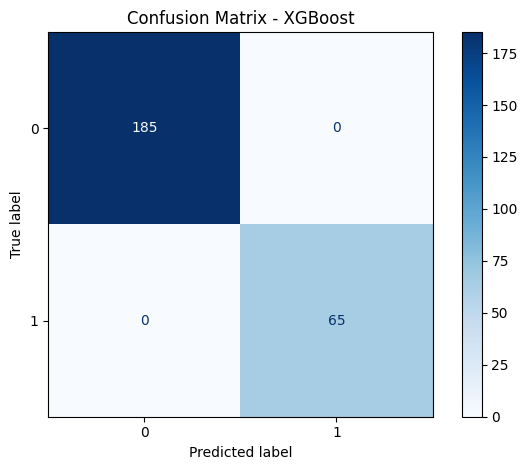

In [6]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.grid(False)
plt.tight_layout()
plt.show()

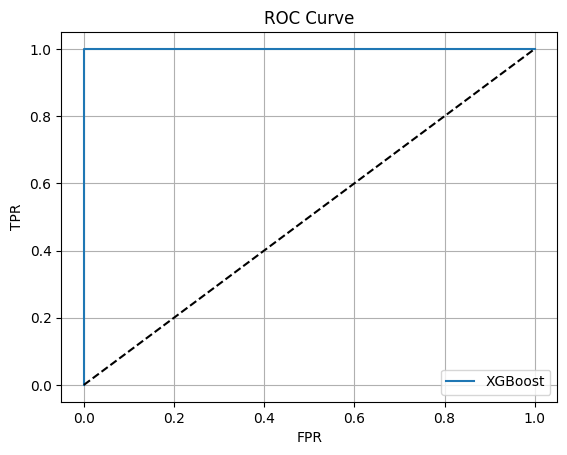

In [7]:
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True)
plt.show()

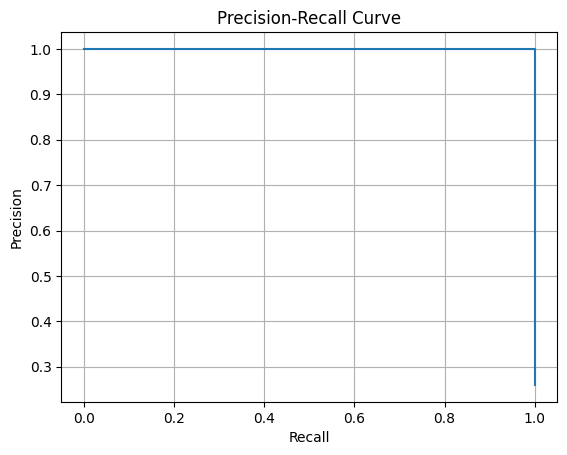

In [8]:
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

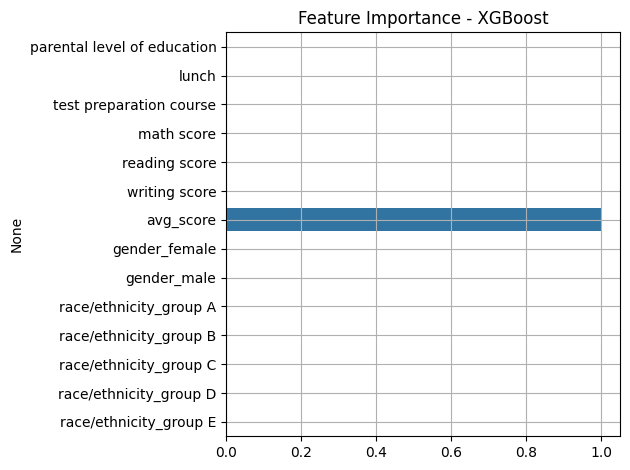

In [9]:
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title('Feature Importance - XGBoost')
plt.tight_layout()
plt.grid(True)
plt.show()

In [12]:
# 1. Simulate attendance_rate
np.random.seed(42)
df["attendance_rate"] = np.round(np.random.uniform(0.6, 1.0, len(df)), 2)

# 2. Ensure 'at_risk' column exists (or regenerate if needed)
if "at_risk" not in df.columns:
    df["at_risk"] = ((df["math score"] < 60) | 
                     (df["reading score"] < 60) | 
                     (df["writing score"] < 60)).astype(int)

# 3. Save final DataFrame for Tableau
df.to_csv("../data/tableau_dataset.csv", index=False)
